In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1041.64it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1013.68it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 685.34it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### Exact Method 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, warmstart=True, conecheck=True)

In [13]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9978, Train Regret:  12.8715%, Val Regret:  12.4236%
Epoch   2, Loss:  -0.9992, Train Regret:   2.9000%, Val Regret:   3.5813%
Epoch   4, Loss:  -1.0000, Train Regret:   2.0042%, Val Regret:   2.6490%
Epoch   6, Loss:  -1.0000, Train Regret:   1.2965%, Val Regret:   1.9441%
Epoch   8, Loss:  -1.0000, Train Regret:   1.2239%, Val Regret:   1.6270%
Epoch  10, Loss:  -1.0000, Train Regret:   1.0652%, Val Regret:   1.4140%
Epoch  12, Loss:  -0.9999, Train Regret:   0.9501%, Val Regret:   1.3241%
Epoch  14, Loss:  -1.0000, Train Regret:   0.9341%, Val Regret:   1.2161%
Epoch  16, Loss:  -1.0000, Train Regret:   0.8335%, Val Regret:   1.1907%
Epoch  18, Loss:  -1.0000, Train Regret:   0.7998%, Val Regret:   0.9386%
Elapsed Time: 75.43 Sec


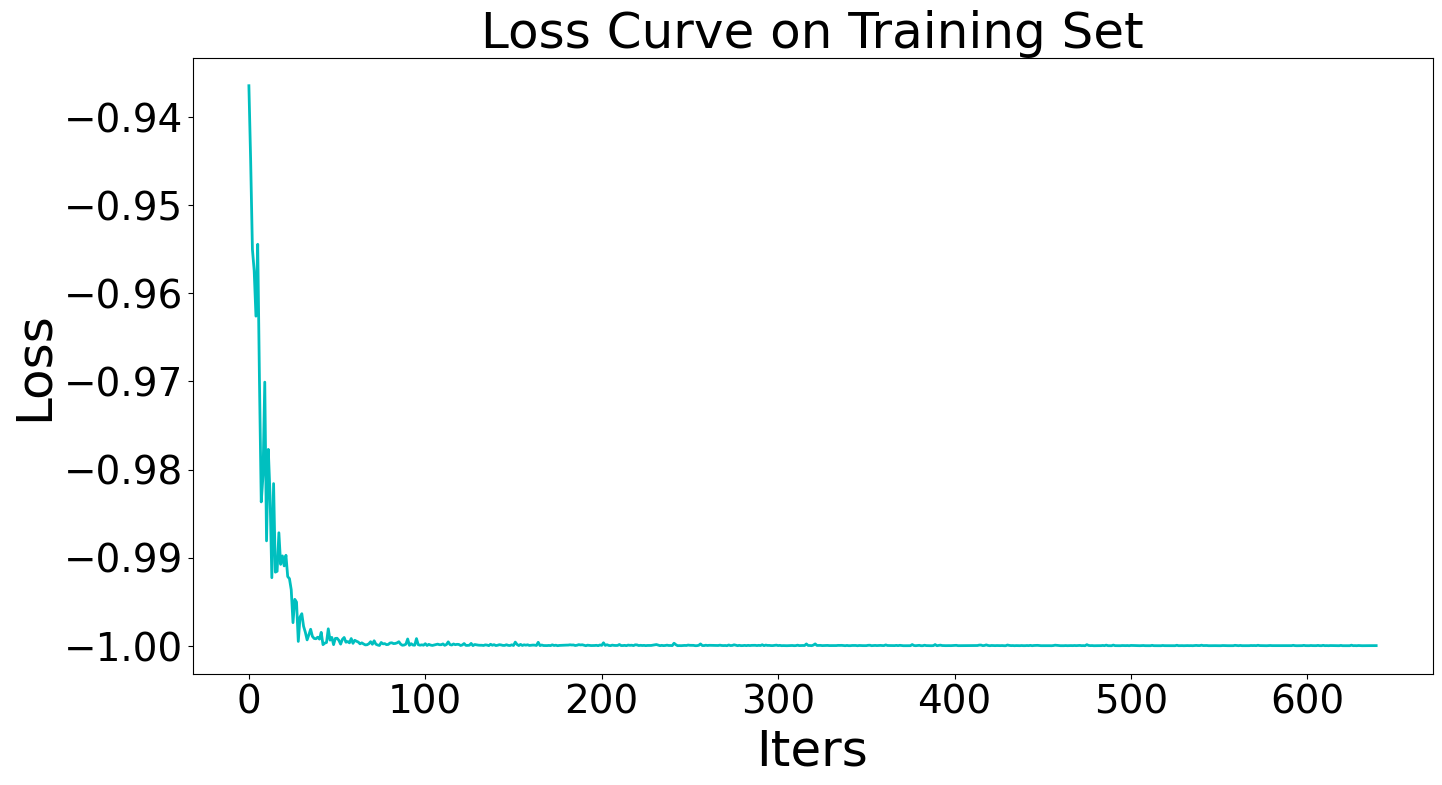

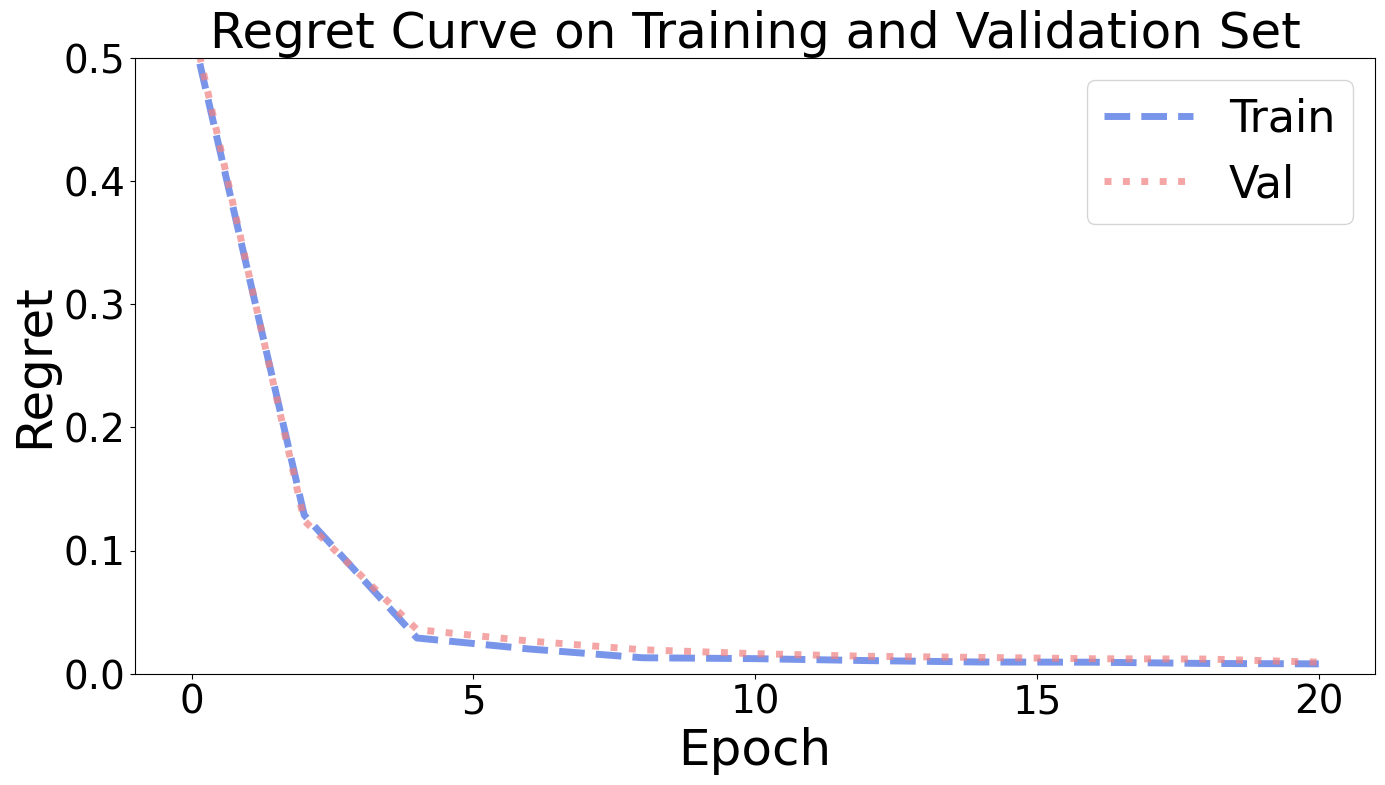

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel, conecheck=False)

In [17]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9969, Train Regret:  14.9699%, Val Regret:  12.7391%
Epoch   2, Loss:  -0.9998, Train Regret:   3.4869%, Val Regret:   4.1026%
Epoch   4, Loss:  -1.0000, Train Regret:   2.3195%, Val Regret:   2.7715%
Epoch   6, Loss:  -1.0000, Train Regret:   1.8150%, Val Regret:   1.9016%
Epoch   8, Loss:  -1.0000, Train Regret:   1.5158%, Val Regret:   1.5053%
Epoch  10, Loss:  -1.0000, Train Regret:   1.2670%, Val Regret:   1.3752%
Epoch  12, Loss:  -1.0000, Train Regret:   1.0142%, Val Regret:   1.1831%
Epoch  14, Loss:  -1.0000, Train Regret:   0.8860%, Val Regret:   0.9856%
Epoch  16, Loss:  -0.9998, Train Regret:   0.8923%, Val Regret:   0.9454%
Epoch  18, Loss:  -1.0000, Train Regret:   0.7983%, Val Regret:   0.9388%
Elapsed Time: 10.71 Sec


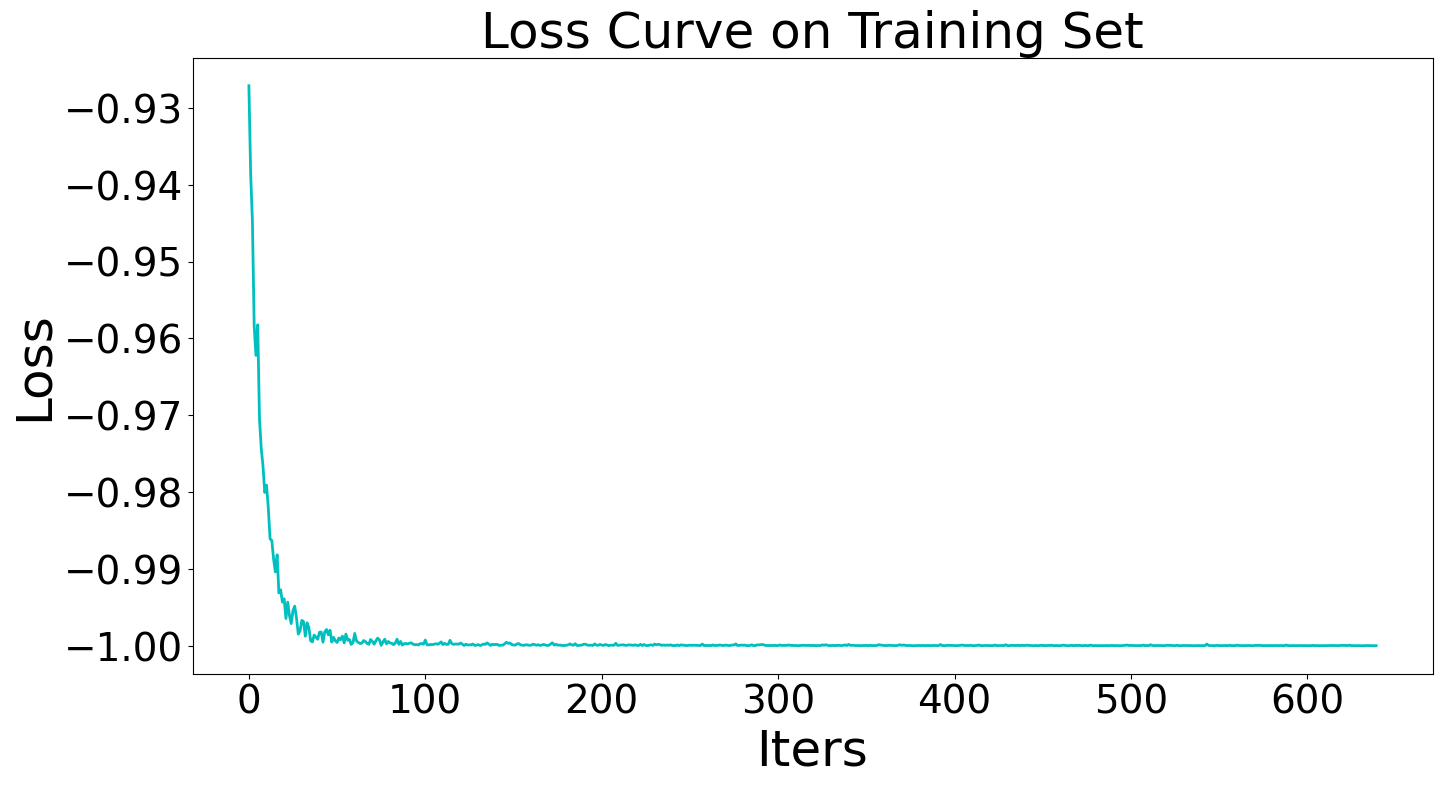

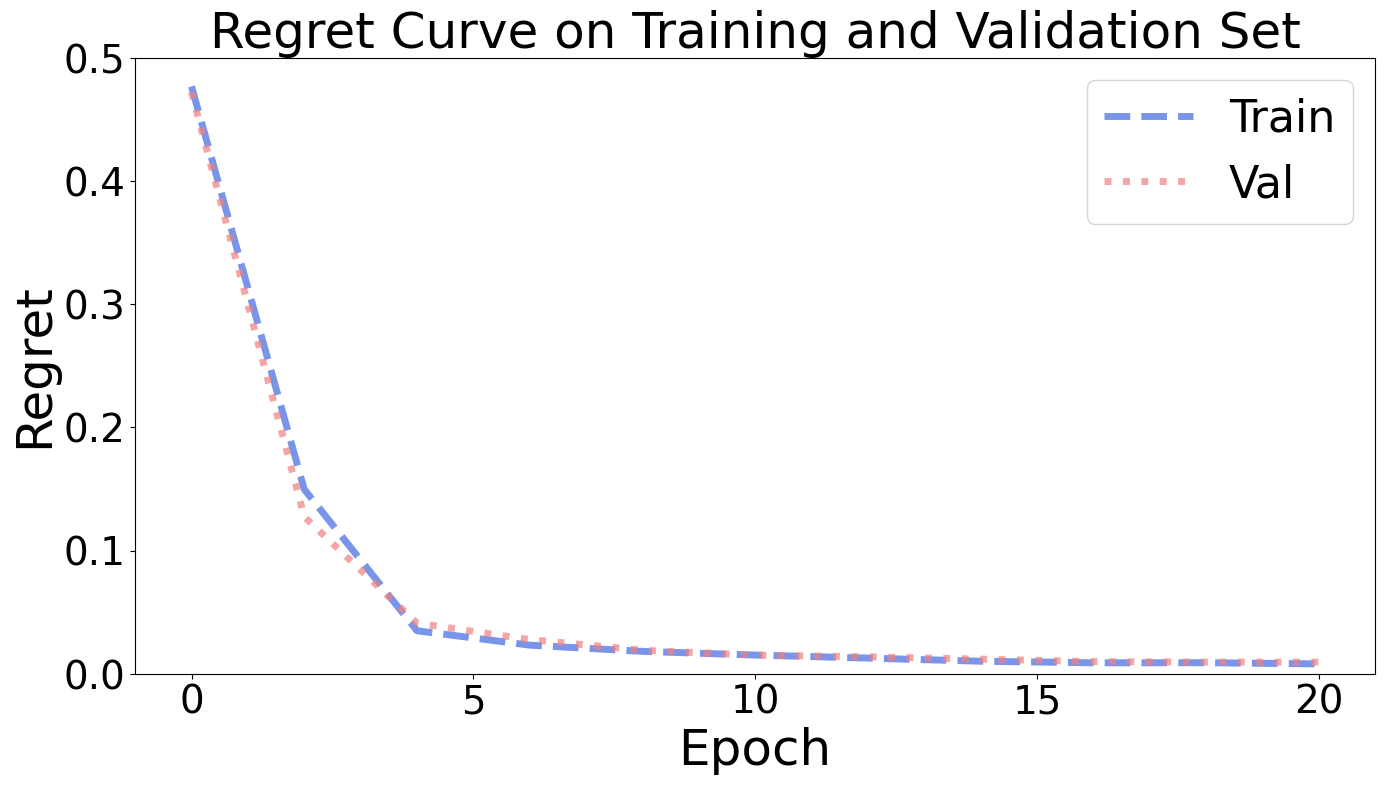

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Vector Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import avgVectConeAlignedCosine

# init loss
ca_cos = avgVectConeAlignedCosine(optmodel)

In [21]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.5353, Train Regret:  12.5674%, Val Regret:  12.4940%
Epoch   2, Loss:  -0.7976, Train Regret:   2.1672%, Val Regret:   2.4414%
Epoch   4, Loss:  -0.8080, Train Regret:   2.2969%, Val Regret:   2.7221%
Epoch   6, Loss:  -0.7978, Train Regret:   2.2885%, Val Regret:   2.8195%
Epoch   8, Loss:  -0.8059, Train Regret:   2.4249%, Val Regret:   2.8091%
Epoch  10, Loss:  -0.8135, Train Regret:   2.5999%, Val Regret:   2.8803%
Epoch  12, Loss:  -0.7936, Train Regret:   2.3758%, Val Regret:   2.5087%
Epoch  14, Loss:  -0.8232, Train Regret:   2.3371%, Val Regret:   2.9487%
Epoch  16, Loss:  -0.8187, Train Regret:   2.4987%, Val Regret:   2.9470%
Epoch  18, Loss:  -0.7826, Train Regret:   2.3796%, Val Regret:   2.7378%
Elapsed Time: 0.98 Sec


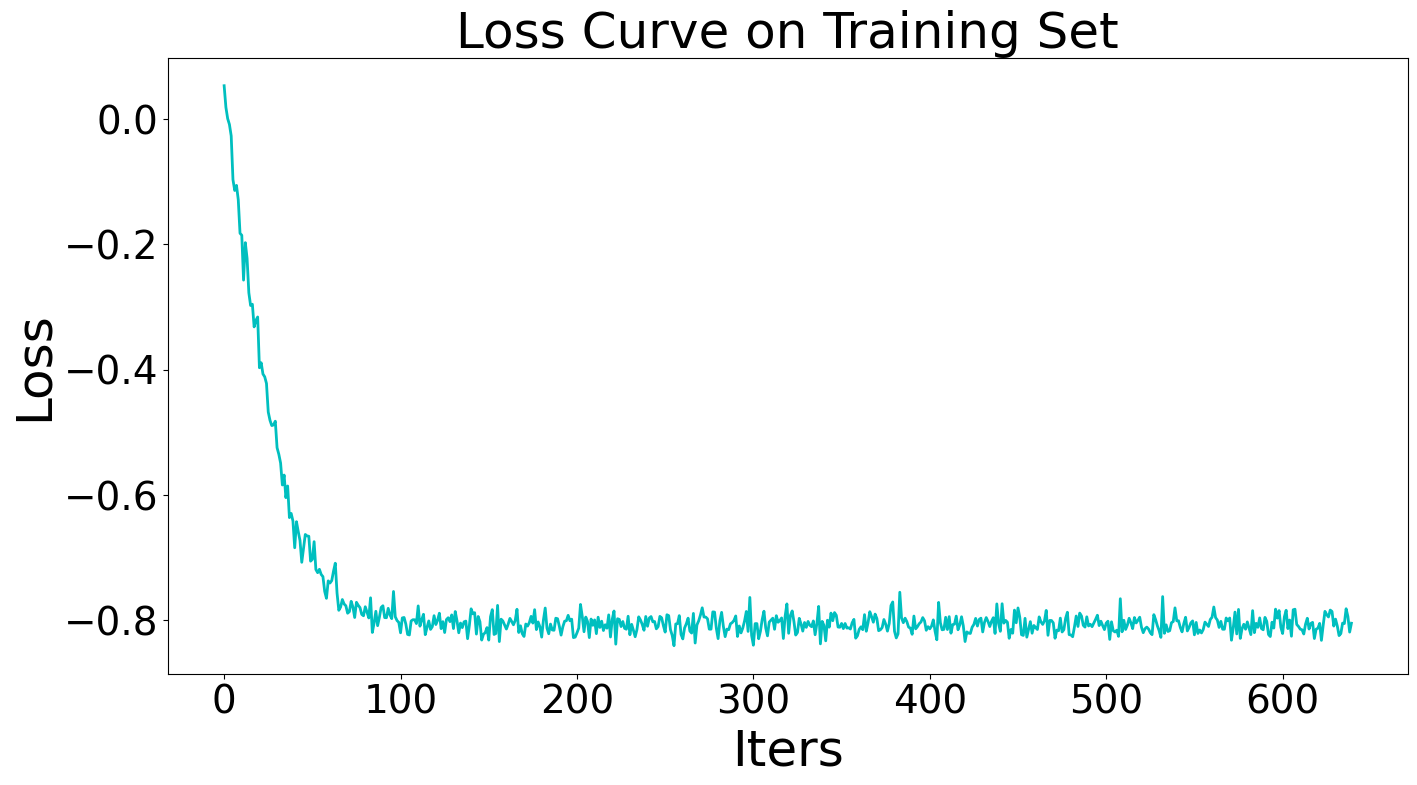

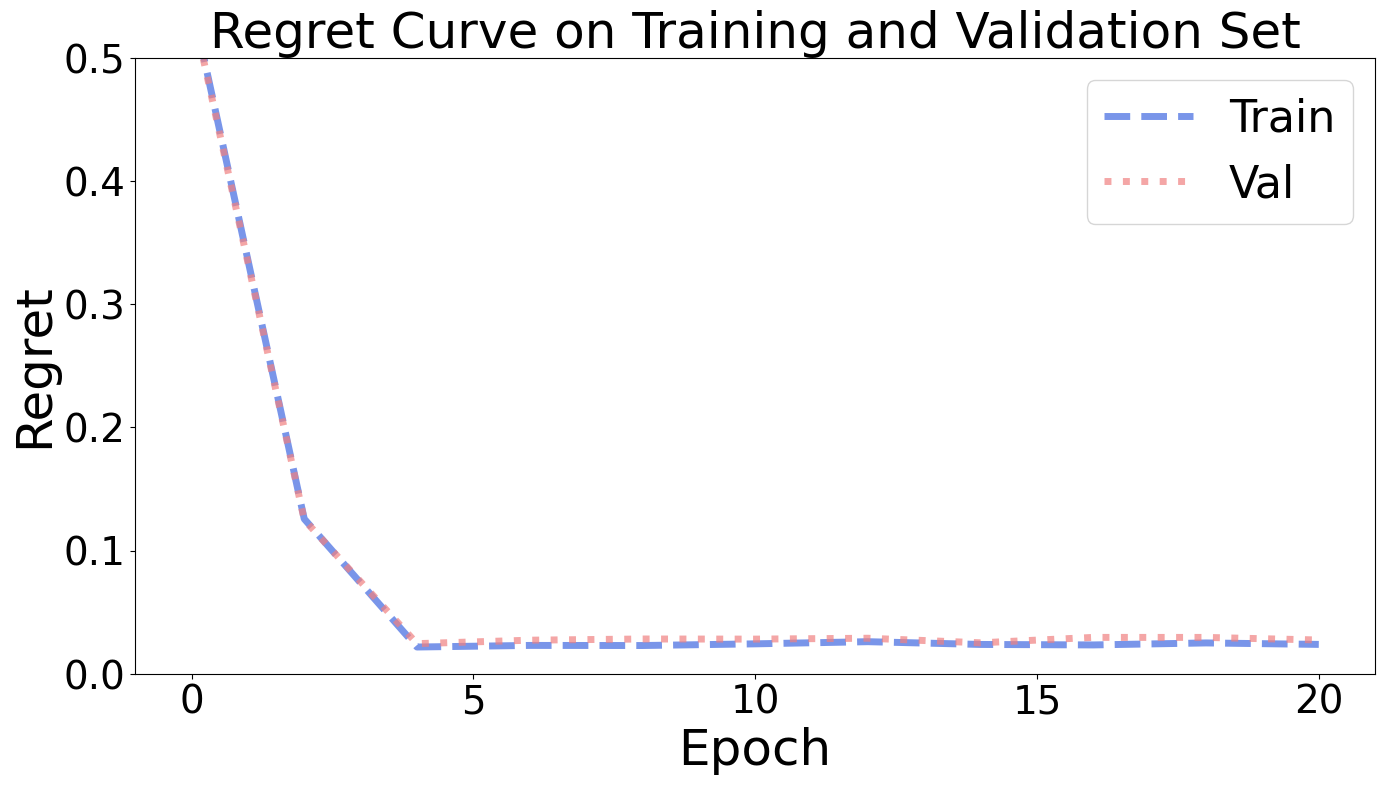

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.5314, Train Regret:  12.3937%, Val Regret:  12.1562%
Epoch   2, Loss:  -0.6687, Train Regret:   2.3081%, Val Regret:   2.8208%
Epoch   4, Loss:  -0.6899, Train Regret:   2.2695%, Val Regret:   2.7350%
Epoch   6, Loss:  -0.7033, Train Regret:   2.3294%, Val Regret:   2.8465%
Epoch   8, Loss:  -0.6856, Train Regret:   2.4131%, Val Regret:   2.8804%
Epoch  10, Loss:  -0.6937, Train Regret:   2.3827%, Val Regret:   2.7248%
Epoch  12, Loss:  -0.7164, Train Regret:   2.3933%, Val Regret:   2.7532%
Epoch  14, Loss:  -0.6776, Train Regret:   2.6472%, Val Regret:   3.0481%
Epoch  16, Loss:  -0.6890, Train Regret:   2.5471%, Val Regret:   3.0787%
Epoch  18, Loss:  -0.7016, Train Regret:   2.3035%, Val Regret:   2.9157%
Elapsed Time: 4.25 Sec


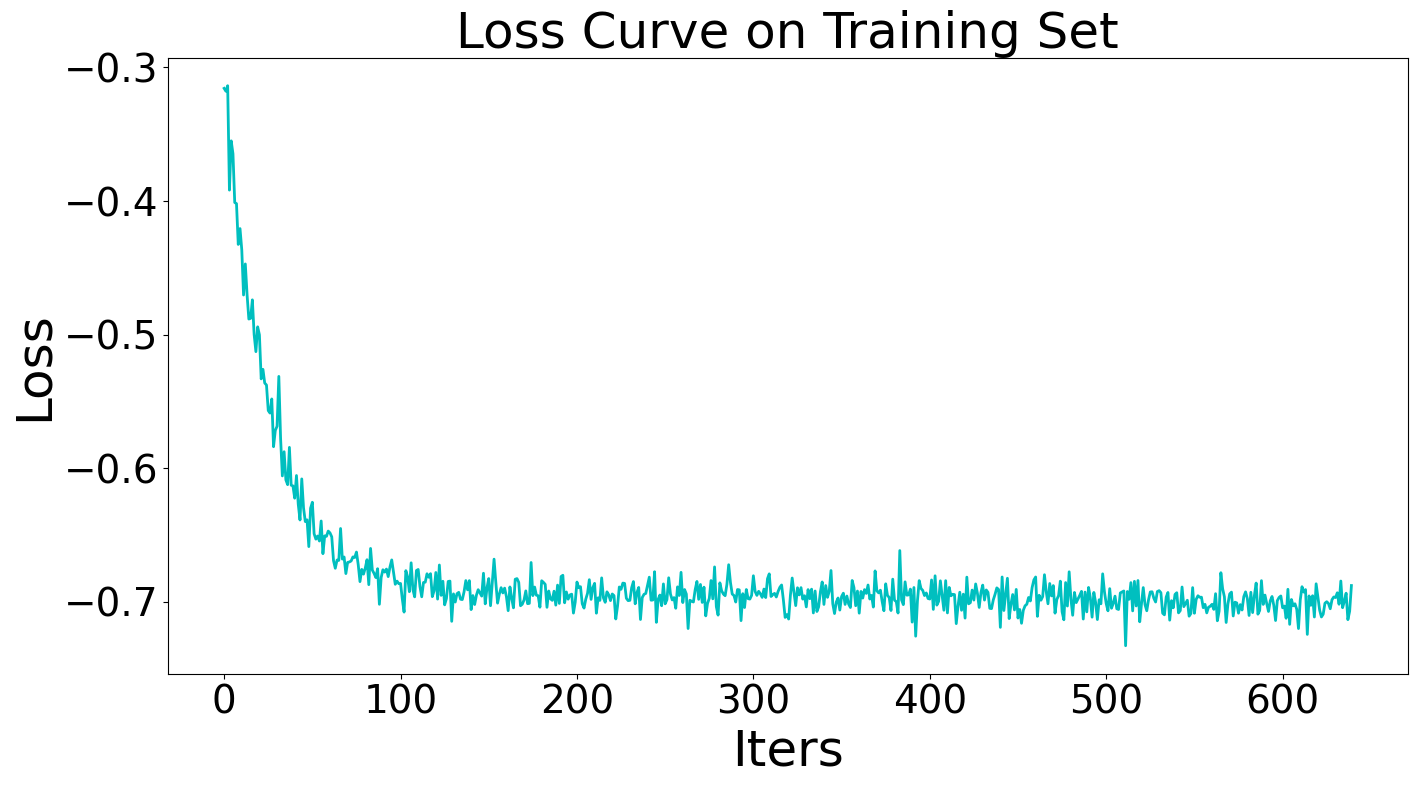

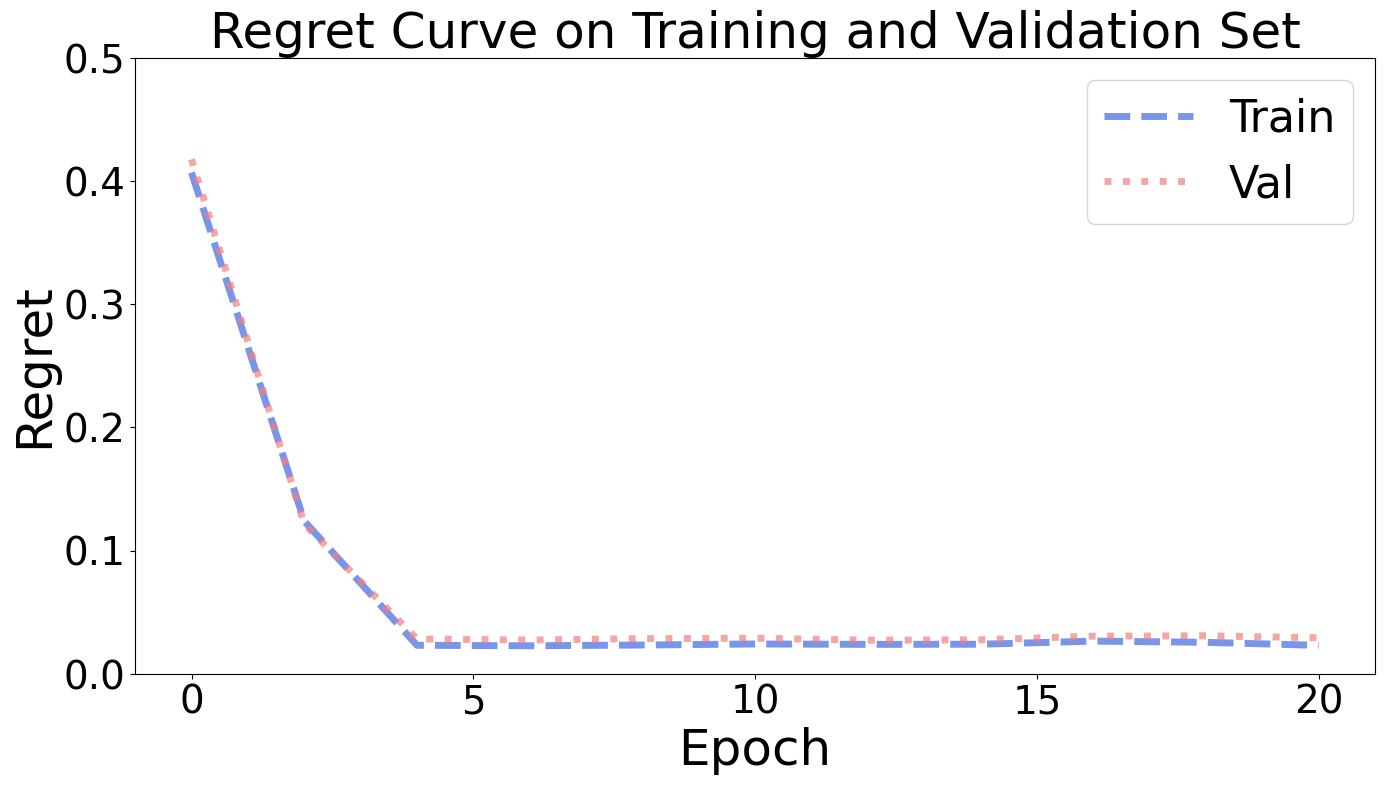

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [27]:
# init model
reg = LinearRegression()

In [28]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [29]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9575, Train Regret:  11.8293%, Val Regret:  12.4610%
Epoch   2, Loss:  -0.9949, Train Regret:   3.2098%, Val Regret:   3.6611%
Epoch   4, Loss:  -0.9927, Train Regret:   3.0996%, Val Regret:   3.5283%
Epoch   6, Loss:  -0.9833, Train Regret:   2.9595%, Val Regret:   3.6316%
Epoch   8, Loss:  -0.9978, Train Regret:   3.1841%, Val Regret:   3.9367%
Epoch  10, Loss:  -0.9963, Train Regret:   3.2444%, Val Regret:   3.7837%
Epoch  12, Loss:  -0.9952, Train Regret:   3.5924%, Val Regret:   4.0007%
Epoch  14, Loss:  -0.9972, Train Regret:   3.9329%, Val Regret:   4.0712%
Epoch  16, Loss:  -0.9947, Train Regret:   3.9022%, Val Regret:   4.4878%
Epoch  18, Loss:  -0.9987, Train Regret:   4.3768%, Val Regret:   4.8308%
Elapsed Time: 0.97 Sec


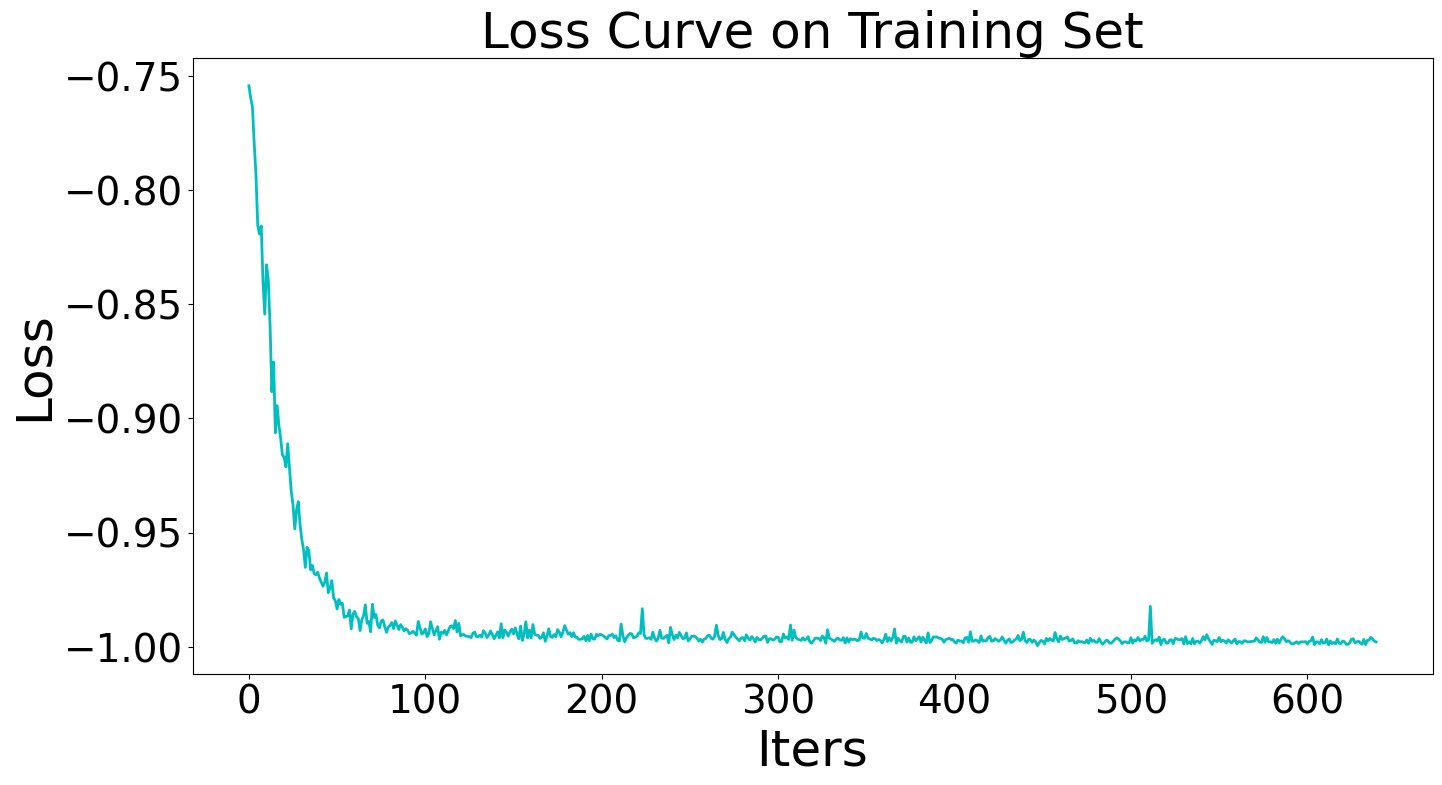

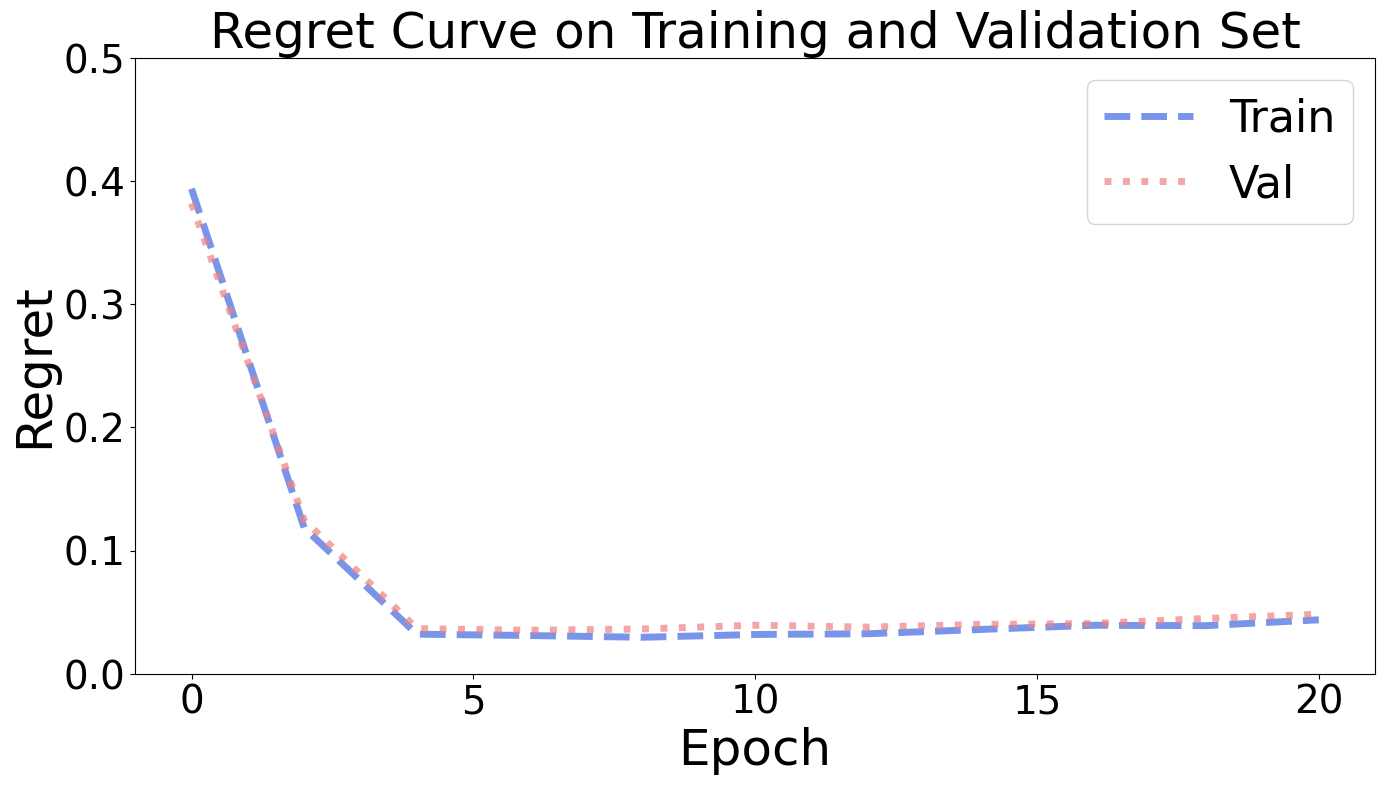

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)